In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
import shap
import pickle
import cloudpickle
import numpy as np
from comparers import ModelComparer
from explainers import generate_shap_explanations
from plots import plot_decision_boundary, plot_2d, plot_feature_importance_bar, plot_feature_importance_scatter,\
                  plot_feature_effects, plot_forces
from util import calc_feature_order, calc_class_order, calc_instance_order
import pandas as pd
import diro2c
from data_generation.helper import prepare_df
from data_generation.neighborhood_generation import neighbor_generator
from enums.diff_classifier_method_type import diff_classifier_method_type
from mlxtend.plotting import plot_decision_regions
from sklearn.tree import plot_tree
import rule_extractor
shap.initjs()
%matplotlib inline
task_name = '02'

In [2]:
with open(task_name + '.dataset', 'rb') as f:
    X, y, feature_names = pickle.load(f)
with open(task_name + '.models', 'rb') as f:
    comparer = pickle.load(f)

# Explain using Interpretability Methods

Prepare dataset for diro2c

In [3]:
idx_explain = 0

In [4]:
feature1 = []
feature2 = []
for x in X:
    feature1.append(x[0])
    feature2.append(x[1])

feature1 = np.asarray(feature1)
feature2 = np.asarray(feature2)

y = y.astype(str)

d = {'y': y, 'feature_1': feature1, 'feature_2': feature2}

df = pd.DataFrame(d)

dataset = prepare_df(df, 'test', 'y')

## Binary difference explanations

In [5]:
diff_classifiers_info = diro2c.recognize_diff(idx_explain, X, dataset, comparer.clf_a, comparer.clf_b,
                                              diff_classifier_method_type.binary_diff_classifier,
                                              data_generation_function=neighbor_generator.get_genetic_neighborhood)

In [6]:
dc_info = diff_classifiers_info['binary_diff_classifer']
dc_full = dc_info['dc_full']
dc_test = dc_info['dc_test']
evaluation_info = dc_info['evaluation_info']

X_diff = evaluation_info['X']
y_diff = evaluation_info['y']

print(np.unique(y_diff, return_counts=True))

(array([0, 1]), array([1285,  257]))


Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.


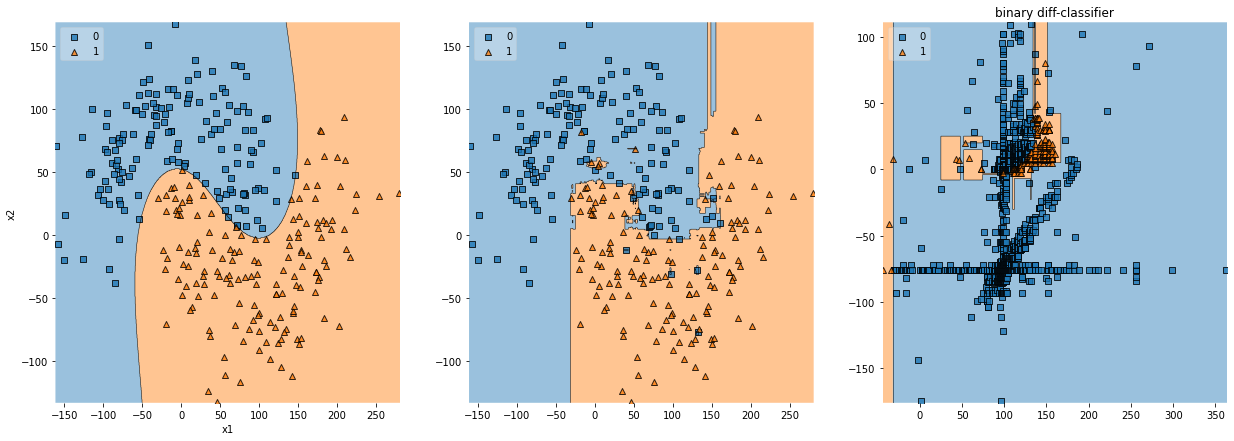

In [7]:
y_pred_a = comparer.clf_a.predict(X)
y_pred_b = comparer.clf_b.predict(X)

fig, ax = plt.subplots(1, 3, figsize=(21, 7))

fig = plot_decision_regions(X=X, y=y_pred_a.astype(
    np.int64), clf=comparer.clf_a, ax=ax[0], legend=2)
ax[0].set_xlabel(feature_names[0])
ax[0].set_ylabel(feature_names[1])
plt.title('blackbox 1')

fig = plot_decision_regions(X=X, y=y_pred_b.astype(
    np.int64), clf=comparer.clf_b, ax=ax[1], legend=2)
ax[0].set_xlabel(feature_names[0])
ax[0].set_ylabel(feature_names[1])
plt.title('blackbox 2')

fig = plot_decision_regions(X=X_diff, y=y_diff.astype(
    np.integer), clf=dc_full, ax=ax[2], legend=2)
ax[0].set_xlabel(feature_names[0])
ax[0].set_ylabel(feature_names[1])
plt.title('binary diff-classifier')

plt.show()

[Text(497.15425531914894, 868.25, 'x1 <= 130.5\ngini = 0.278\nsamples = 1542\nvalue = [1285, 257]\nclass = no_diff'),
 Text(286.9148936170213, 792.75, 'x1 <= 111.5\ngini = 0.123\nsamples = 1244\nvalue = [1162, 82]\nclass = no_diff'),
 Text(98.93617021276596, 717.25, 'x1 <= -31.5\ngini = 0.032\nsamples = 853\nvalue = [839, 14]\nclass = no_diff'),
 Text(79.14893617021276, 641.75, 'gini = 0.0\nsamples = 4\nvalue = [0, 4]\nclass = diff'),
 Text(118.72340425531914, 641.75, 'x1 <= 73.5\ngini = 0.023\nsamples = 849\nvalue = [839, 10]\nclass = no_diff'),
 Text(39.57446808510638, 566.25, 'x2 <= -7.5\ngini = 0.123\nsamples = 91\nvalue = [85, 6]\nclass = no_diff'),
 Text(19.78723404255319, 490.75, 'gini = 0.0\nsamples = 77\nvalue = [77, 0]\nclass = no_diff'),
 Text(59.36170212765957, 490.75, 'x2 <= 24.0\ngini = 0.49\nsamples = 14\nvalue = [8, 6]\nclass = no_diff'),
 Text(39.57446808510638, 415.25, 'x1 <= 24.5\ngini = 0.48\nsamples = 10\nvalue = [4, 6]\nclass = diff'),
 Text(19.78723404255319, 339

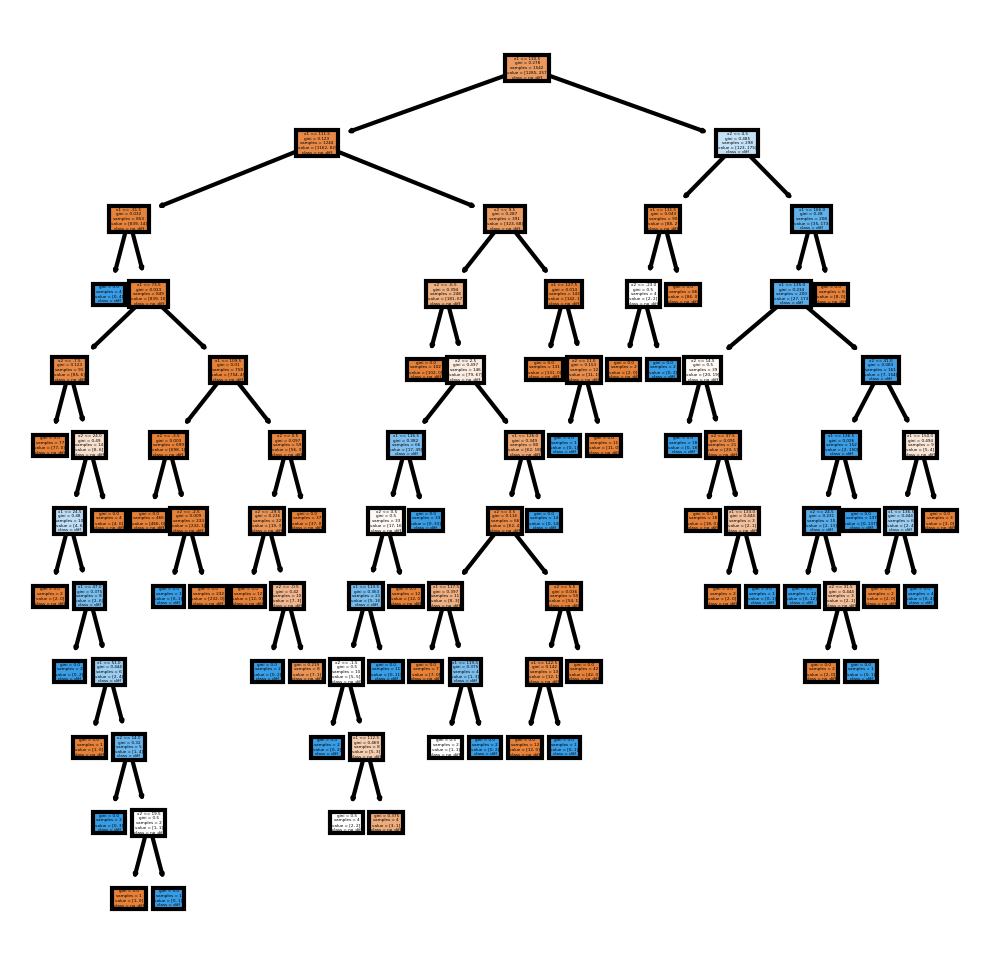

In [8]:
cn = ['no_diff', 'diff']
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), dpi=300)
plot_tree(dc_full,
               feature_names=feature_names,
               class_names=cn,
               filled=True)

In [9]:
rule_extractor.print_rules_for_binary(
    dc_full, dataset['columns_for_decision_rules'], ['no_diff', 'diff'], 'diff')

{'diff': '{feature_1 <= 130.5, feature_1 <= 111.5, feature_1 <= -31.5}'}
{'diff': '{feature_1 <= 130.5, feature_1 <= 111.5, feature_1 > -31.5, feature_1 <= 73.5, feature_2 > -7.5, feature_2 <= 24.0, feature_1 > 24.5, feature_1 <= 47.0}'}
{'diff': '{feature_1 <= 130.5, feature_1 <= 111.5, feature_1 > -31.5, feature_1 <= 73.5, feature_2 > -7.5, feature_2 <= 24.0, feature_1 > 24.5, feature_1 > 47.0, feature_1 > 51.0, feature_2 <= 14.0}'}
{'diff': '{feature_1 <= 130.5, feature_1 <= 111.5, feature_1 > -31.5, feature_1 <= 73.5, feature_2 > -7.5, feature_2 <= 24.0, feature_1 > 24.5, feature_1 > 47.0, feature_1 > 51.0, feature_2 > 14.0, feature_2 > 19.5}'}
{'diff': '{feature_1 <= 130.5, feature_1 <= 111.5, feature_1 > -31.5, feature_1 > 73.5, feature_1 <= 109.5, feature_2 > -3.5, feature_2 <= -2.5}'}
{'diff': '{feature_1 <= 130.5, feature_1 <= 111.5, feature_1 > -31.5, feature_1 > 73.5, feature_1 > 109.5, feature_2 <= 0.5, feature_2 > -29.5, feature_2 <= -0.5}'}
{'diff': '{feature_1 <= 130.5, 

## Multiclass difference explanations

In [10]:
multiclass_diff_names = ['(0, 0)', '(1, 1)', '(1, 0)', '(0, 1)']

In [11]:
diff_classifiers_info = diro2c.recognize_diff(idx_explain, X, dataset, comparer.clf_a, comparer.clf_b,
                                              diff_classifier_method_type.multiclass_diff_classifier,
                                              data_generation_function=neighbor_generator.get_genetic_neighborhood)

In [12]:
dc_info = diff_classifiers_info['multiclass_diff_classifer']
dc_full = dc_info['dc_full']
dc_test = dc_info['dc_test']
evaluation_info = dc_info['evaluation_info']

X_diff = evaluation_info['X']
y_diff = evaluation_info['y']

print(np.unique(y_diff, return_counts=True))

(array([1, 2, 3, 4]), array([644, 942, 283,  14]))


You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


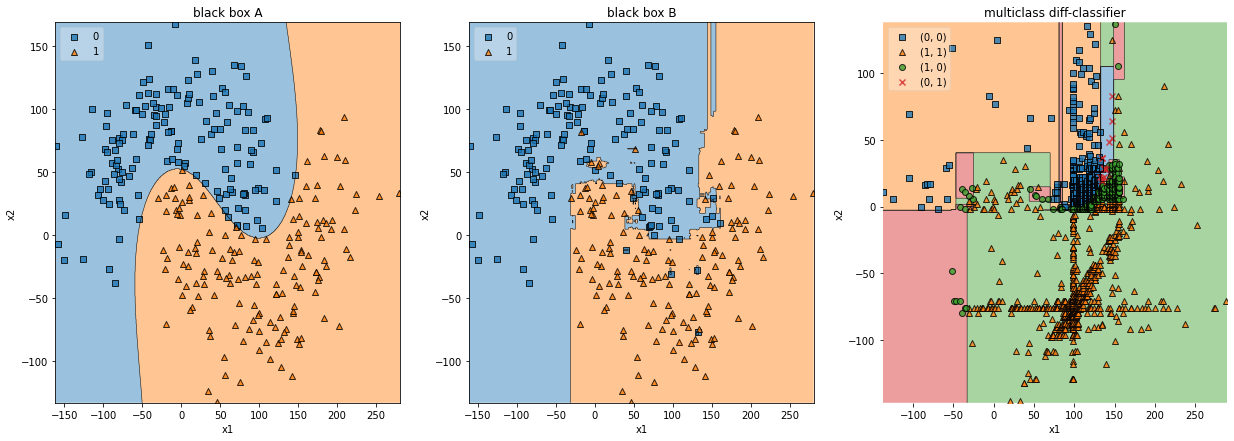

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(21, 7))

fig = plot_decision_regions(X=X, y=y_pred_a.astype(
    np.int64), clf=comparer.clf_a, ax=ax[0], legend=2, hide_spines=False)
ax[0].set_xlabel(feature_names[0])
ax[0].set_ylabel(feature_names[1])
ax[0].set_title('black box A')

fig = plot_decision_regions(X=X, y=y_pred_b.astype(
    np.int64), clf=comparer.clf_b, ax=ax[1], legend=2, hide_spines=False)
ax[1].set_xlabel(feature_names[0])
ax[1].set_ylabel(feature_names[1])
ax[1].set_title('black box B')

fig = plot_decision_regions(X=X_diff, y=y_diff.astype(
    np.int64), clf=dc_full, ax=ax[2], legend=2)
ax[2].set_xlabel(feature_names[0])
ax[2].set_ylabel(feature_names[1])
ax[2].set_title('multiclass diff-classifier')

handles, labels = ax[2].get_legend_handles_labels()
ax[2].legend(handles,
             multiclass_diff_names,
             framealpha=0.3, scatterpoints=1)

plt.show()


[Text(303.8352272727273, 864.8181818181819, 'x2 <= -1.5\ngini = 0.61\nsamples = 1883\nvalue = [644, 942, 283, 14]\nclass = (1, 1)'),
 Text(67.63636363636364, 782.4545454545455, 'x2 <= -2.5\ngini = 0.1\nsamples = 874\nvalue = [2, 828, 44, 0]\nclass = (1, 1)'),
 Text(33.81818181818182, 700.0909090909091, 'x1 <= -33.0\ngini = 0.018\nsamples = 792\nvalue = [0, 785, 7, 0]\nclass = (1, 1)'),
 Text(16.90909090909091, 617.7272727272727, 'gini = 0.0\nsamples = 7\nvalue = [0, 0, 7, 0]\nclass = (1, 0)'),
 Text(50.727272727272734, 617.7272727272727, 'gini = 0.0\nsamples = 785\nvalue = [0, 785, 0, 0]\nclass = (1, 1)'),
 Text(101.45454545454547, 700.0909090909091, 'x1 <= 121.5\ngini = 0.521\nsamples = 82\nvalue = [2, 43, 37, 0]\nclass = (1, 1)'),
 Text(84.54545454545455, 617.7272727272727, 'x1 <= 62.5\ngini = 0.387\nsamples = 49\nvalue = [2, 10, 37, 0]\nclass = (1, 0)'),
 Text(50.727272727272734, 535.3636363636364, 'x1 <= -32.5\ngini = 0.37\nsamples = 9\nvalue = [1, 7, 1, 0]\nclass = (1, 1)'),
 Text

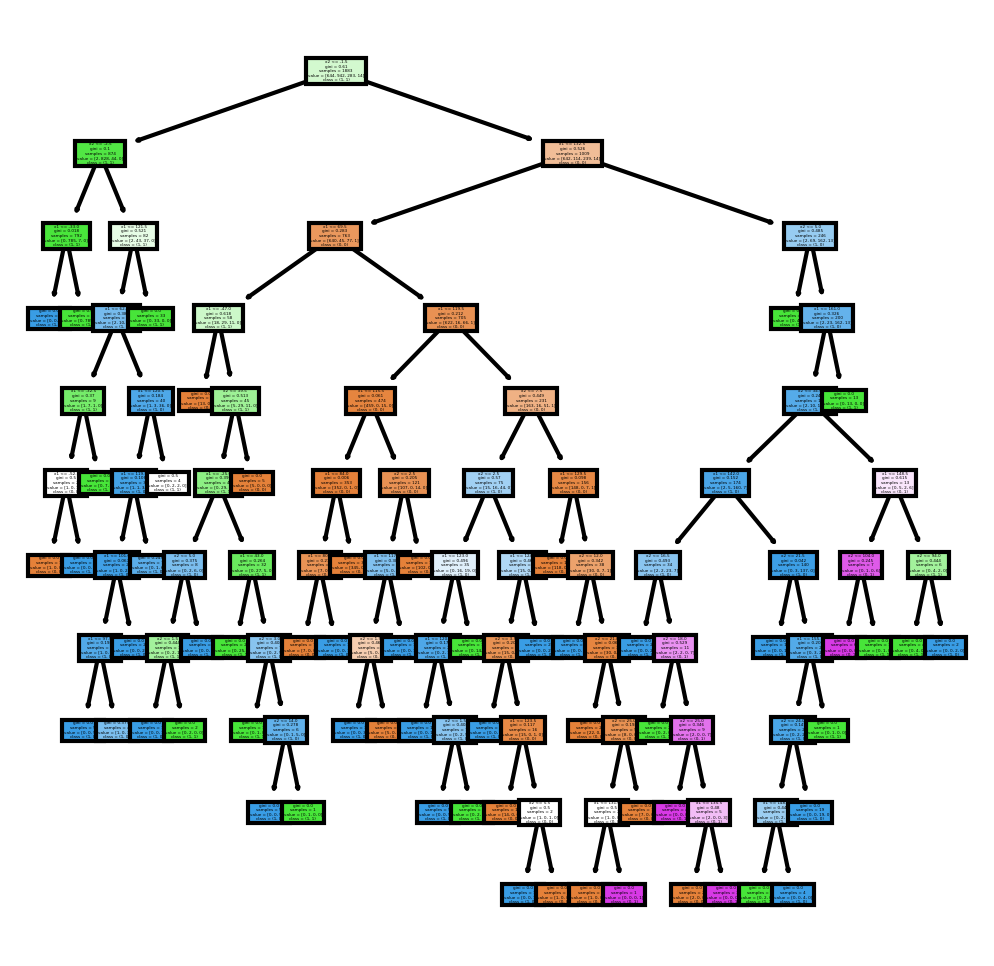

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), dpi=300)
plot_tree(dc_full,
               feature_names=feature_names,
               class_names=multiclass_diff_names,
               filled=True)